In [1]:
import os
import subprocess
from pathlib import Path
from typing import List, Optional
import re

import networkx as nx
from clang import cindex

# ──────────────────── Clang init ───────────────────────────────────
_CLANG_INITIALIZED = False

def _init_clang() -> None:
    global _CLANG_INITIALIZED
    if _CLANG_INITIALIZED:
        return
    for p in [
        "/usr/lib/llvm-18/lib",
        "/usr/lib/llvm-17/lib",
        "/usr/lib/llvm-16/lib",
        "/usr/lib/llvm-15/lib",
        "/usr/lib64/llvm",
        "/usr/lib/x86_64-linux-gnu",
        "/usr/lib/llvm/lib",
    ]:
        lib = Path(p) / "libclang.so"
        if lib.exists():
            try:
                cindex.Config.set_library_file(str(lib))
                cindex.Config.set_compatibility_check(False)
                _ = cindex.Index.create()
                _CLANG_INITIALIZED = True
                print(f"✅ libclang loaded from: {lib}")
                return
            except Exception as e:
                print(f"⚠️ Failed to load {lib}: {e}")
    raise RuntimeError("libclang.so not found - install clang (libclang-dev)")

_init_clang()

# ──────────────────── Helpers ─────────────────────────────────────

def base_name_variants(name: str) -> set:
    variants = set()
    if not name:
        return variants
    variants.add(name)
    name_no_ret = name.split()[-1]
    variants.add(name_no_ret)
    no_args = re.sub(r'\(.*\)', '', name_no_ret)
    variants.add(no_args)
    base = no_args.split("::")[-1]
    variants.add(base)
    no_template = re.sub(r'<.*?>', '', base)
    variants.add(no_template)
    return {v.strip() for v in variants if v.strip()}

def is_mangled(name: str) -> bool:
    return name.startswith("_Z")

def demangle(name: str) -> str:
    if not is_mangled(name):
        return name
    try:
        out = subprocess.run(["c++filt", name], capture_output=True, text=True)
        if out.returncode == 0 and out.stdout.strip():
            return out.stdout.strip()
    except FileNotFoundError:
        pass
    return name

def fq_name(cur: cindex.Cursor) -> str:
    parts = []
    c = cur
    while c and c.kind != cindex.CursorKind.TRANSLATION_UNIT:
        if c.kind in (
            cindex.CursorKind.NAMESPACE,
            cindex.CursorKind.CLASS_DECL,
            cindex.CursorKind.STRUCT_DECL,
            cindex.CursorKind.CLASS_TEMPLATE,
        ):
            parts.append(c.spelling)
        c = c.semantic_parent
    parts.reverse()
    if cur.spelling:
        parts.append(cur.spelling)
    n = "::".join(parts)
    return demangle(n) if is_mangled(n) else n

def read_extent(cur: cindex.Cursor) -> str:
    ext = cur.extent
    if not ext or not ext.start.file:
        return ""
    try:
        with open(ext.start.file.name, "r", encoding="utf-8", errors="ignore") as f:
            lines = f.readlines()
        return "".join(lines[ext.start.line - 1 : ext.end.line])
    except Exception:
        return ""

def outline_ast(cur: cindex.Cursor, depth=0) -> List[str]:
    lines = ["  " * depth + cur.kind.name]
    for c in cur.get_children():
        lines.extend(outline_ast(c, depth + 1))
    return lines

# ──────────────────── Traversal ────────────────────────────────────

FUNC_KINDS = {
    cindex.CursorKind.FUNCTION_DECL,
    cindex.CursorKind.CXX_METHOD,
    cindex.CursorKind.FUNCTION_TEMPLATE,
}

TYPE_KINDS = {
    cindex.CursorKind.CLASS_DECL,
    cindex.CursorKind.STRUCT_DECL,
    cindex.CursorKind.CLASS_TEMPLATE,
    # ADD THESE:
    cindex.CursorKind.TYPEDEF_DECL,
    cindex.CursorKind.TYPE_ALIAS_DECL,
    cindex.CursorKind.TYPE_ALIAS_TEMPLATE_DECL,
    cindex.CursorKind.ENUM_DECL,
}

TEMPLATE_PARAM_KINDS = {
    cindex.CursorKind.TEMPLATE_TYPE_PARAMETER,
    cindex.CursorKind.TEMPLATE_NON_TYPE_PARAMETER,
    cindex.CursorKind.TEMPLATE_TEMPLATE_PARAMETER,
}


def loc_info(cur: cindex.Cursor) -> dict:
    loc = cur.location
    return {"file": str(loc.file) if loc.file else "", "line": loc.line, "col": loc.column}

def collect_nodes(cursor: cindex.Cursor, G: nx.DiGraph, root: Path) -> None:
    def in_proj(c: cindex.Cursor) -> bool:
        return bool(c.location.file) and Path(c.location.file.name).resolve().is_relative_to(root)

    def ensure_node(name: str, kind: str, cur: Optional[cindex.Cursor]):
        if name not in G:
            G.add_node(name, kind=kind, code="", ast="", cursor=None, **(loc_info(cur) if cur else {}))
        if cur:
            if G.nodes[name]["code"] == "":
                G.nodes[name]["code"] = read_extent(cur)
            if G.nodes[name]["ast"] == "":
                try:
                    G.nodes[name]["ast"] = "\n".join(outline_ast(cur))
                except Exception:
                    G.nodes[name]["ast"] = "<AST outline unavailable>"
            if G.nodes[name]["cursor"] is None:
                G.nodes[name]["cursor"] = cur

    if cursor.kind in FUNC_KINDS and cursor.is_definition() and in_proj(cursor):
        fq = fq_name(cursor)
        ensure_node(fq, "function", cursor)

    if cursor.kind in TYPE_KINDS and in_proj(cursor):
        fq = fq_name(cursor)
        ensure_node(fq, "type", cursor)

    for child in cursor.get_children():
        collect_nodes(child, G, root)


def collect_edges(cursor: cindex.Cursor, ctx_func: Optional[str], G: nx.DiGraph, root: Path) -> None:
    def in_proj(c: cindex.Cursor) -> bool:
        return bool(c.location.file) and Path(c.location.file.name).resolve().is_relative_to(root)

    # Update context if we're inside a known function or template
    if cursor.kind in FUNC_KINDS and cursor.is_definition() and in_proj(cursor):
        ctx_func = fq_name(cursor)

    # If we're inside a function and hit a call expression, try to resolve it
    if cursor.kind == cindex.CursorKind.CALL_EXPR and ctx_func:
        callee_name = None
        raw_spelling = ""

        # 1) Direct reference resolution
        if cursor.referenced and cursor.referenced.kind in FUNC_KINDS:
            callee_name = fq_name(cursor.referenced)
            raw_spelling = cursor.referenced.spelling or ""

        # 2) Fallback: child inspection for DECL_REF_EXPR
        if not callee_name:
            for child in cursor.get_children():
                if (
                    child.kind == cindex.CursorKind.DECL_REF_EXPR and
                    child.spelling and
                    (not child.referenced or child.referenced.kind in FUNC_KINDS)
                ):
                    raw_spelling = child.spelling
                    if child.referenced and child.referenced.kind in FUNC_KINDS:
                        callee_name = fq_name(child.referenced)
                    else:
                        variants = base_name_variants(child.spelling)
                        matches = [
                            n for n, d in G.nodes(data=True)
                            if d.get("kind") == "function" and variants & base_name_variants(n)
                        ]
                        if len(matches) == 1:
                            callee_name = matches[0]
                        elif len(matches) > 1:
                            print(f"⚠️ Ambiguous call to '{child.spelling}'; candidates: {matches}")
                        else:
                            print(f"⚠️ Could not resolve call to '{child.spelling}' from '{ctx_func}'")
                    break

        # 3) Record edge if successful
        if callee_name and ctx_func != callee_name:
            loc = cursor.location
            location = (str(loc.file), loc.line)
            G.add_edge(ctx_func, callee_name, type="call", location=location, raw=raw_spelling)

    # If we're inside a function and hit a reference to a class/type, record it
    if cursor.kind == cindex.CursorKind.TYPE_REF and ctx_func and in_proj(cursor):
        decl = cursor.referenced or cursor.get_definition() or cursor.get_type().get_declaration()
        if not decl:
            return
        if decl.kind in TEMPLATE_PARAM_KINDS:
            return  # ✅ Ignore references to template parameters

        if in_proj(decl):
            type_name = fq_name(decl)
            if type_name not in G:
                G.add_node(
                    type_name,
                    kind="type",
                    code="",
                    ast="",
                    cursor=decl,
                    **loc_info(decl)
                )
                print(f"⚠️ Missing node for type '{type_name}'")
                print(f"Location: {loc_info(decl)}")
            loc = cursor.location
            G.add_edge(
                ctx_func,
                type_name,
                type="type-ref",
                location=(str(loc.file), loc.line)
            )

    # ✅ Recurse into all children
    for child in cursor.get_children():
        collect_edges(child, ctx_func, G, root)


# ──────────────────── Parsing helpers ──────────────────────────────

def parse_file(index: cindex.Index, p: Path) -> Optional[cindex.TranslationUnit]:
    """
    Parse a single file and return any matching function declarations along with the translation unit.
    """
    # print(f"Searching for '{target_name}' in {file_path}")
    try:
        # Add compiler arguments for modern C++
        compiler_args = [
            '-x', 'c++',              # Force C++ mode
            '-std=c++17',             # Use C++17
            '-I/usr/include',         # System includes
            '-I/usr/local/include',
            '-I.',                    # Current directory
            '-Isrc',                  # Common source directory
            '-Iinclude',              # Another common source directory
            '-I..',                   # Parent directory
            '-fparse-all-comments',   # Parse all comments
            '-Wno-unknown-warning-option',  # Ignore unknown warnings
            '-ferror-limit=0',        # Don't stop on errors
            '-D__clang_analyzer__',   # Enable clang analyzer
            '-ftemplate-depth=1024',  # Increase template recursion depth
            '-finstantiate-templates',  # Instantiate templates
        ]
        
        # Add the source directory and its parent to include paths
        src_dir = os.path.dirname(p)
        if src_dir:
            compiler_args.extend([f'-I{src_dir}'])
            parent_dir = os.path.dirname(src_dir)
            if parent_dir:
                compiler_args.extend([f'-I{parent_dir}'])
                
                # Add potential include directories that might exist in the project structure
                potential_dirs = ['include', 'src', 'lib']
                for p_dir in potential_dirs:
                    full_path = os.path.join(parent_dir, p_dir)
                    if os.path.isdir(full_path):
                        compiler_args.extend([f'-I{full_path}'])
        

            # compiler_args.extend(['-fdelayed-template-parsing'])
        
        return index.parse(
            p,
            args=compiler_args,
            options=cindex.TranslationUnit.PARSE_DETAILED_PROCESSING_RECORD
        )  
    except Exception as e:
        print(f"Error parsing {p}: {e}")
        return None

# ──────────────────── File discovery ───────────────────────────────

def cpp_files(root: Path) -> List[Path]:
    return [Path(dp) / f for dp, _, files in os.walk(root)
            for f in files if f.endswith((".cpp", ".cc", ".cxx", ".c", ".hpp", ".h"))]

# ──────────────────── Build graph ─────────────────────────────────-

def build_graph(root: Path) -> nx.DiGraph:
    idx = cindex.Index.create()
    G = nx.DiGraph()
    for fp in cpp_files(root):
        tu = parse_file(idx, fp)
        if tu:
            collect_nodes(tu.cursor, G, root)
    for fp in cpp_files(root):
        tu = parse_file(idx, fp)
        if tu:
            collect_edges(tu.cursor, None, G, root)
    return G


# ──────────────────── Notebook run ─────────────────────────────────
PROJECT_DIR = Path("tmp/adiprerepa").resolve()
graph = build_graph(PROJECT_DIR)

# Remove nodes with no file label
for n in list(graph.nodes):
    if 'file' not in graph.nodes[n] or not graph.nodes[n]['file']:
        graph.remove_node(n)

✅ libclang loaded from: /usr/lib/llvm-18/lib/libclang.so


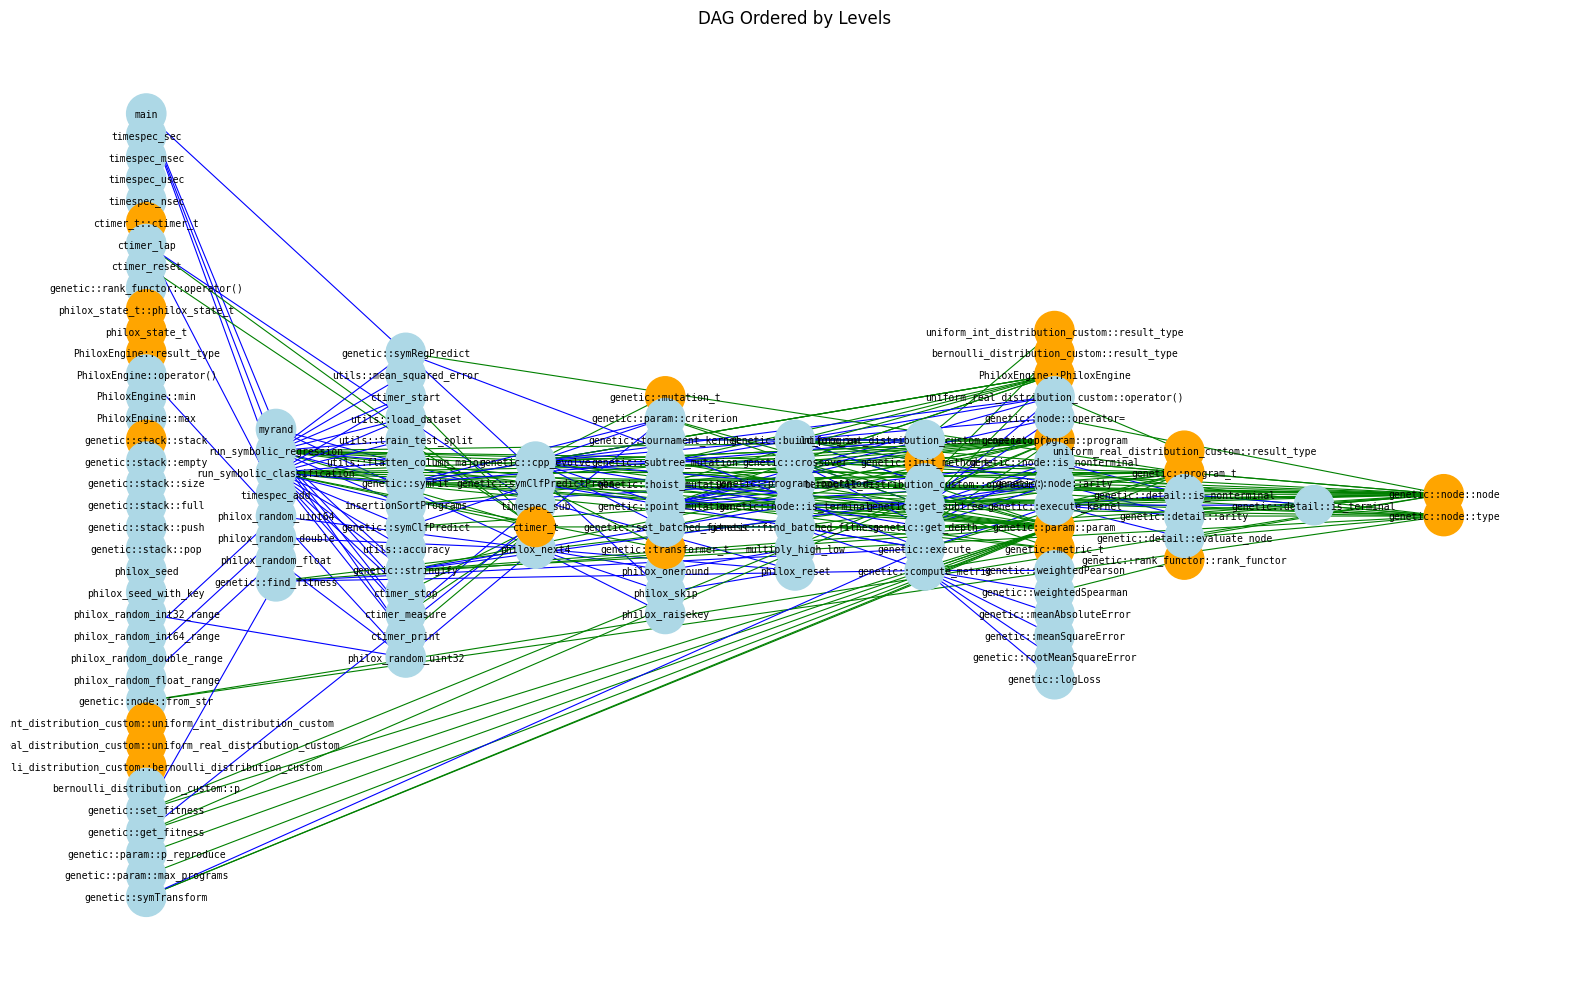

In [2]:
from collections import defaultdict
import matplotlib.pyplot as plt

def plot_dag_by_levels(G, horizontal=False):
    if not nx.is_directed_acyclic_graph(G):
        raise ValueError("Input graph must be a Directed Acyclic Graph (DAG)")

    # Compute node levels using topological sort
    levels = {}
    for node in nx.topological_sort(G):
        preds = list(G.predecessors(node))
        levels[node] = 0 if not preds else 1 + max(levels[p] for p in preds)

    # Group nodes by levels
    level_nodes = defaultdict(list)
    for node, lvl in levels.items():
        level_nodes[lvl].append(node)

    # Assign positions with increased spacing
    pos = {}
    max_level = max(level_nodes.keys()) if level_nodes else 0
    max_nodes_per_level = max(len(nodes) for nodes in level_nodes.values()) if level_nodes else 0
    
    # Define spacing factors
    horizontal_spacing = 2.0  # Increase for more horizontal space
    vertical_spacing = 1.5    # Increase for more vertical space
    
    for level, nodes in level_nodes.items():
        for i, node in enumerate(nodes):
            # Center nodes at each level horizontally
            offset = (max_nodes_per_level - len(nodes)) / 2
            if horizontal:
                pos[node] = (level * horizontal_spacing, -(i + offset) * vertical_spacing)
            else:
                pos[node] = ((i + offset) * horizontal_spacing, -level * vertical_spacing)

    # Define node colors based on their kind
    node_colors = []
    for node in G.nodes:
        kind = G.nodes[node].get("kind", "unknown")
        if kind == "function":
            node_colors.append("lightblue")
        elif kind == "class":
            node_colors.append("lightgreen")
        elif kind == "type":
            node_colors.append("orange")
        else:
            node_colors.append("gray")

    # Define edge colors based on their type
    edge_colors = []
    for u, v, data in G.edges(data=True):
        edge_type = data.get("type", "unknown")
        if edge_type == "call":
            edge_colors.append("blue")
        elif edge_type == "type-ref":
            edge_colors.append("green")
        else:
            edge_colors.append("gray")

    # Draw
    plt.figure(figsize=(16, 10))  # Larger figure size
    
    # Draw edges
    nx.draw_networkx_edges(
        G, pos, 
        arrowstyle='-|>', 
        arrowsize=10, 
        edge_color=edge_colors,
        width=0.8
    )
    
    # Draw nodes
    nx.draw_networkx_nodes(
        G, pos, 
        node_size=800,  # Smaller node size
        node_color=node_colors
    )
    
    # Draw labels with smaller font
    nx.draw_networkx_labels(
        G, pos, 
        font_size=7,  # Smaller font size
        font_family='monospace'
    )
    
    plt.title("DAG Ordered by Levels")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

plot_dag_by_levels(graph, horizontal=True)

In [3]:
import re

print("\n--- Nodes with degree 0 --- that don't deserve it")
function_nodes = [n for n, d in graph.nodes(data=True) if d["kind"] == "function"]

whitelist = {'min', 'max', 'empty', 'size', 'full'}

for n in function_nodes:
    token = n.split("::")[-1]
    if token in whitelist: continue
    if graph.degree(n) == 0:
        # get the bare function name (no namespaces)
        
        # build a regex that:
        #  - won’t match inside larger identifiers
        #  - won’t match parts of a namespace like “My::foo” inside “My::foobar”
        # (?<![\w:])  = not preceded by a word‑char or colon
        # (?![\w])    = not followed by a word‑char
        pat = re.compile(r"(?<![\w:])" + re.escape(token) + r"(?![\w])")
        
        for m in function_nodes:
            if m == n:
                continue

            code = graph.nodes[m]["code"]
            for match in pat.finditer(code):
                print("=========")
                print(f"Node {n} is referenced in {m}:")
                # location info
                loc_n = graph.nodes[n]
                loc_m = graph.nodes[m]
                print(f"  {n} defined at {loc_n['file']}:{loc_n['line']}")
                print(f"  {m} defined at {loc_m['file']}:{loc_m['line']}")
                
                # show the snippet around the match
                start, end = match.span()
                snippet = code[max(0, start-30):min(len(code), end+30)]
                # highlight the match with brackets
                highlighted = snippet.replace(
                    snippet[start - max(0, start-30): end - max(0, start-30)],
                    f"[{token}]"
                )
                print("  code context:", highlighted)
                
                # optionally print full code+AST if you still need it
                print(graph.nodes[m]['code'])
                print(graph.nodes[m]['ast'])
                print("==========\n")
                # once we’ve found one match, we can stop scanning this m
                break



--- Nodes with degree 0 --- that don't deserve it


In [4]:
node = 'genetic::detail::is_terminal'
if node in graph:
    code = graph.nodes[node]['code']
    successors = list(graph.successors(node))
    print(f"\nCode for {node}:\n{code}")
    ast = graph.nodes[node]['ast']
    print(f"AST for {node}:\n{ast}")
    print(f"Successors: {successors}")


Code for genetic::detail::is_terminal:
inline bool is_terminal(node::type t) {
  return t == node::type::variable || t == node::type::constant;
}

AST for genetic::detail::is_terminal:
FUNCTION_DECL
  PARM_DECL
    TYPE_REF
    TYPE_REF
  COMPOUND_STMT
    RETURN_STMT
      BINARY_OPERATOR
        BINARY_OPERATOR
          UNEXPOSED_EXPR
            DECL_REF_EXPR
          DECL_REF_EXPR
            TYPE_REF
            TYPE_REF
        BINARY_OPERATOR
          UNEXPOSED_EXPR
            DECL_REF_EXPR
          DECL_REF_EXPR
            TYPE_REF
            TYPE_REF
Successors: ['genetic::node::node', 'genetic::node::type']


## Obfuscation

In [5]:
from __future__ import annotations

import hashlib
import os
import textwrap
from pathlib import Path
from typing import Dict, Set, List, Tuple

from clang import cindex
from clang.cindex import CursorKind
import random

from utils.string_utils import remove_comments


class Obfuscator:
    def __init__(self, tier: int, project_root: Path, prefix: str = "o_"):
        if not (0 <= tier <= 4):
            raise ValueError("tier must be between 0 and 4")
        self.tier = tier
        self.project_root = project_root.resolve()
        self.prefix = prefix

    @property
    def strip_comments(self) -> bool:
        return self.tier == 0

    @property
    def obfuscate_library(self) -> bool:
        return self.tier >= 4

    @property
    def kinds_to_obfuscate(self) -> Set[cindex.CursorKind]:
        if self.tier == 0:
            return set()
        kinds = set()
        for priority, ks in CURSOR_KINDS_BY_PRIORITY.items():
            if priority <= self.tier:
                kinds.update(ks)
        return kinds

    def should_obfuscate_cursor(self, cursor: cindex.Cursor) -> bool:
        if cursor is None or cursor.kind == CursorKind.TRANSLATION_UNIT:
            return False
        if cursor.kind not in self.kinds_to_obfuscate:
            return False
        if self.obfuscate_library:
            return True
        return _is_user_defined(cursor, project_root=self.project_root, obfuscate_library=self.obfuscate_library)

    def collect_tokens_from_cursors(self, cursors: List[cindex.Cursor]) -> Set[str]:
        tokens: Set[str] = set()

        def _recurse(cur: cindex.Cursor) -> None:
            if self.should_obfuscate_cursor(cur):
                if cur.spelling:
                    tokens.add(cur.spelling)
            for child in cur.get_children():
                _recurse(child)

        for cursor in cursors:
            _recurse(cursor)

        return tokens

    def create_obfuscation_map(self, tokens: Set[str]) -> Dict[str, str]:
        obf_map: Dict[str, str] = {}
        for token in sorted(tokens):
            digest = hashlib.sha1(token.encode()).hexdigest()[:8]
            obf_map[token] = f"{self.prefix}{digest}"
        return obf_map

    def obfuscate_code(self, code: str, obf_map: Dict[str, str]) -> str:
        pattern = _compiled_word_pattern(set(obf_map))

        def repl(match: re.Match[str]) -> str:
            return obf_map[match.group(0)]

        return pattern.sub(repl, code)

    def obfuscate(self, code: str, cursors: List[cindex.Cursor]) -> Tuple[str, Dict[str, str]]:
        if self.strip_comments:
            code = remove_comments(code)
        tokens = self.collect_tokens_from_cursors(cursors)
        obf_map = self.create_obfuscation_map(tokens)
        return self.obfuscate_code(code, obf_map), obf_map


def _is_user_defined(
    cursor: cindex.Cursor, *, project_root: Path, obfuscate_library: bool
) -> bool:
    definition = cursor.get_definition()
    loc_file = (
        definition.location.file.name
        if definition and definition.location.file
        else cursor.location.file.name
        if cursor.location.file
        else None
    )

    if loc_file is None:
        return obfuscate_library

    file_path = Path(loc_file).resolve()
    project_root = project_root.resolve()

    try:
        in_project = file_path.is_relative_to(project_root)
    except AttributeError:
        in_project = str(file_path).startswith(str(project_root))

    is_writeable = os.access(file_path, os.W_OK)
    return in_project or is_writeable or obfuscate_library


import re

_word_pat_cache: Dict[frozenset, re.Pattern] = {}

def _compiled_word_pattern(words: set[str]) -> re.Pattern:
    key = frozenset(words)
    pat = _word_pat_cache.get(key)
    if pat is None:
        altern = "|".join(map(re.escape, sorted(words, key=len, reverse=True)))
        pat = re.compile(rf"(?<!\w)(?:{altern})(?!\w)")
        _word_pat_cache[key] = pat
    return pat


CURSOR_KINDS_BY_PRIORITY: Dict[int, Set[CursorKind]] = {
    3: {
        CursorKind.FUNCTION_DECL,
        CursorKind.CXX_METHOD,
        CursorKind.FUNCTION_TEMPLATE,
        CursorKind.CALL_EXPR,
        CursorKind.VAR_DECL,
        CursorKind.PARM_DECL,
        CursorKind.RETURN_STMT,
        CursorKind.COMPOUND_STMT,
        CursorKind.IF_STMT,
        CursorKind.FOR_STMT,
        CursorKind.WHILE_STMT,
        CursorKind.SWITCH_STMT,
        CursorKind.CASE_STMT,
    },
    2: {
        CursorKind.TYPE_REF,
        CursorKind.DECL_REF_EXPR,
        CursorKind.STRUCT_DECL,
        CursorKind.CLASS_DECL,
        CursorKind.CLASS_TEMPLATE,
        CursorKind.FIELD_DECL,
        CursorKind.MEMBER_REF_EXPR,
        CursorKind.NAMESPACE,
        CursorKind.NAMESPACE_REF,
    },
    1: {
        CursorKind.TEMPLATE_TYPE_PARAMETER,
        CursorKind.TEMPLATE_REF,
        CursorKind.USING_DECLARATION,
        CursorKind.INCLUSION_DIRECTIVE,
        CursorKind.MACRO_DEFINITION,
        CursorKind.MACRO_INSTANTIATION,
        CursorKind.LINKAGE_SPEC,
        CursorKind.ANNOTATE_ATTR,
        CursorKind.CXX_BASE_SPECIFIER,
    },
    0: {
        CursorKind.TRANSLATION_UNIT,
        CursorKind.UNEXPOSED_EXPR,
        CursorKind.UNEXPOSED_DECL,
        CursorKind.NULL_STMT,
        CursorKind.UNION_DECL,
        CursorKind.ASM_STMT,
        CursorKind.STATIC_ASSERT,
    },
}

obfuscator = Obfuscator(tier=3, project_root=PROJECT_DIR)

random_node = random.choice(list(graph.nodes))
# gather successors
successors = list(graph.successors(random_node))
# obfuscate the node along with succesors
cursors = [graph.nodes[n]["cursor"] for n in successors]
cursors.append(graph.nodes[random_node]["cursor"])
# get the code
code = '\n'.join([graph.nodes[n]["code"] for n in successors])
code += '\n' + graph.nodes[random_node]["code"]
# obfuscate
obfuscated_code, obf_map = obfuscator.obfuscate(code, cursors)

# print the original code
print("\nOriginal code:")
for n in successors:
    print(textwrap.indent(graph.nodes[n]["code"], "  "))
print(textwrap.indent(graph.nodes[random_node]["code"], "  "))

# print the obfuscated code
print("Obfuscated code:")
print(textwrap.indent(obfuscated_code, "  "))
print("\nObfuscation map:")
for original, obfuscated in obf_map.items():
    print(f"  {original} -> {obfuscated}")


Original code:
  template <typename RealType = double> class uniform_real_distribution_custom {
  public:
    using result_type = RealType;

    // Default constructor: range [0, 1)
    uniform_real_distribution_custom() : a_(0), b_(1) {}

    // Constructor takes lower bound 'a' and upper bound 'b'; b must be > a.
    uniform_real_distribution_custom(result_type a, result_type b)
        : a_(a), b_(b) {
      if (b <= a) {
        throw std::invalid_argument("Range error: b must be > a");
      }
    }

    // When called with a random engine, returns a uniformly distributed real
    // number. The engine is expected to provide a uint32_t via operator().
    template <typename Engine> result_type operator()(Engine &eng) {
      // Obtain a raw uint32_t from the engine.
      uint32_t x = eng();
      // Map it to a value in [0, 1) using a standard conversion.
      double u =
          x * (1.0 /
               (static_cast<double>(std::numeric_limits<uint32_t>::max()) + 1.0));
    

[nltk_data] Downloading package words to /home/ayuram/nltk_data...
[nltk_data]   Package words is already up-to-date!
